<a href="https://colab.research.google.com/github/tongnamuu/Tensorflow_Tutorials/blob/master/Tensorflow_tutorials_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf

import numpy as np
import IPython.display as display

TensorFlow 2.x selected.
     |████████████████████████████████| 533.2MB 31kB/s 
     |████████████████████████████████| 2.9MB 48.2MB/s 
     |████████████████████████████████| 2.8MB 45.8MB/s 
     |████████████████████████████████| 460kB 50.7MB/s 
     |████████████████████████████████| 778kB 59.5MB/s 
ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2


In [2]:
def _bytes_feature(value):
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



In [3]:
feature = _float_feature(np.exp(1))
feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

In [0]:
n_observations = int(1e4)
feature0 = np.random.choice([False, True], n_observations)
feature1 = np.random.randint(0, 5, n_observations)
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]
feature3 = np.random.randn(n_observations)

In [0]:
def serialize_example(feature0, feature1, feature2, feature3):
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [6]:
example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?'

In [7]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

In [9]:
tf.data.Dataset.from_tensor_slices(feature1)

<TensorSliceDataset shapes: (), types: tf.int64>

In [10]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64)>

In [12]:
for f0,f1,f2,f3 in features_dataset.take(1):
  print(f0)
  print(f1)
  print(f2)
  print(f3)

tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'dog', shape=(), dtype=string)
tf.Tensor(-1.112824793947413, shape=(), dtype=float64)


In [0]:
def tf_serialize_example(f0,f1,f2,f3):
  tf_string = tf.py_function(
    serialize_example,
    (f0,f1,f2,f3),
    tf.string)
  return tf.reshape(tf_string, ())

In [14]:
tf_serialize_example(f0,f1,f2,f3)

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x0bq\x8e\xbf'>

In [15]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

In [0]:
def generator():
  for features in features_dataset:
    yield serialize_example(*features)

In [0]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=())

In [18]:
serialized_features_dataset

<FlatMapDataset shapes: (), types: tf.string>

In [0]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

In [20]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [21]:
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x0bq\x8e\xbf\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xb3\xe6\xa2\xbe'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xebg\x00>\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x8b\xf6\xbb='>
<tf.Tensor: shape=(), dtype=string, nu

In [22]:
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

In [23]:
for parsed_record in parsed_dataset.take(10):
  print(repr(parsed_record))

{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-1.1128248>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.31816635>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.12539642>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.09177884>}
{'feature0'

In [0]:
with tf.io.TFRecordWriter(filename) as writer:
  for i in range(n_observations):
    example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
    writer.write(example)

In [25]:
!du -sh {filename}

984K	test.tfrecord


In [26]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [27]:
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "dog"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -1.11282479763031
      }
    }
  }
}



In [28]:
cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

16384/15477 [===============================] - 0s 0us/step


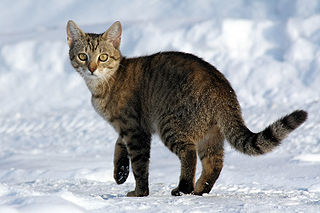

In [29]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

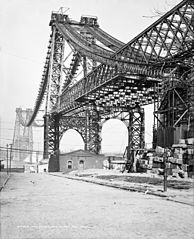

In [30]:
display.display(display.Image(filename=williamsburg_bridge))
display.display(display.HTML('<a "href=https://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg">From Wikimedia</a>'))

In [0]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [32]:
image_string = open(cat_in_snow, 'rb').read()
label = image_labels[cat_in_snow]
def image_example(image_string, label):
  image_shape = tf.image.decode_jpeg(image_string).shape
  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:15]:
  print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
...


In [0]:
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [34]:
!du -sh {record_file}

36K	images.tfrecords


In [35]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

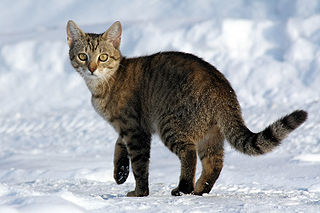

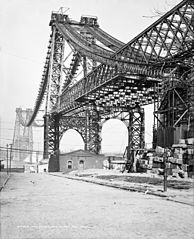

In [36]:
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))